In [1]:
import cupy as cp
import matplotlib.pyplot as plt
import pandas as pd
import sys
import h5py
from types import SimpleNamespace
import warnings
warnings.filterwarnings("ignore", message=f".*peer.*")

from utils import *
from rec_noref import Rec


cp.cuda.set_pinned_memory_allocator(cp.cuda.PinnedMemoryPool().malloc)


## Sizes and propagation settings

In [2]:
npos = 225
th="3920"

In [3]:
path = f'/data/visitors/danmax/20241507/2025060408/viktor/ca_{th}/'
# npos=15
ids = np.arange(npos)
# for k in range(15):    
#     if k%2==1:
#         ids[k*15:(k+1)*15] = ids[k*15:(k+1)*15][::-1]
# ids = ids[::15]
# print(ids,len(ids))

with  h5py.File(f'{path}/data_ca.h5','r') as fid:
    data = np.ascontiguousarray(fid[f'/exchange/pdata'][ids].astype('float32'))
    ref = fid[f'/exchange/pref'][:].astype('float32')
    shifts = np.ascontiguousarray(fid[f'/exchange/shifts'][ids].astype('float32'))    
    psi_init = fid[f'/exchange/psi_init'][:]
    
    z1 = fid['/exchange/z1'][0]
    detector_pixelsize = fid['/exchange/detector_pixelsize'][0]
    focusToDetectorDistance = fid['/exchange/focusdetectordistance'][0]
    energy = fid['/exchange/energy'][0]
print(data.shape,shifts)


(225, 2048, 2048) [[-666. -772.]
 [-693. -652.]
 [-693. -554.]
 [-711. -368.]
 [-693. -314.]
 [-708. -234.]
 [-668. -106.]
 [-745.   69.]
 [-666.   99.]
 [-706.  195.]
 [-671.  288.]
 [-706.  455.]
 [-750.  533.]
 [-691.  633.]
 [-707.  755.]
 [-561.  733.]
 [-625.  680.]
 [-630.  556.]
 [-622.  482.]
 [-576.  312.]
 [-588.  196.]
 [-586.  144.]
 [-646.   94.]
 [-624.  -83.]
 [-635. -230.]
 [-656. -261.]
 [-636. -437.]
 [-599. -488.]
 [-575. -652.]
 [-592. -721.]
 [-471. -697.]
 [-545. -649.]
 [-515. -513.]
 [-533. -483.]
 [-515. -311.]
 [-523. -159.]
 [-505. -131.]
 [-513.   21.]
 [-514.  100.]
 [-552.  282.]
 [-529.  287.]
 [-470.  414.]
 [-470.  489.]
 [-454.  653.]
 [-468.  777.]
 [-349.  804.]
 [-375.  632.]
 [-416.  535.]
 [-439.  459.]
 [-388.  265.]
 [-389.  260.]
 [-447.  171.]
 [-376.   25.]
 [-415. -153.]
 [-432. -159.]
 [-374. -311.]
 [-380. -459.]
 [-396. -533.]
 [-396. -675.]
 [-367. -677.]
 [-298. -697.]
 [-317. -579.]
 [-263. -511.]
 [-286. -362.]
 [-266. -308.]
 [-300.

In [4]:
wavelength = 1.24e-09/energy  
# focusToDetectorDistance = 1.28  
z2 = focusToDetectorDistance-z1
distance = (z1*z2)/focusToDetectorDistance
magnification = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnification)  


In [5]:
args = SimpleNamespace()

args.ngpus = 4
args.lam = 0.0

args.n = 2048
args.npsi = 2048+2048
args.pad = 0
args.nq = args.n + 2 * args.pad
args.ex = 8
args.npatch = args.nq + 2 * args.ex
args.npos = npos
args.nchunk = 4

args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distance
args.eps = 1e-8
args.rho = [1, 2, 0.1]
args.path_out = f"/data/visitors/danmax/20241507/2025060408/viktor/ca_{th}/rec_ca/r_{args.lam}_{args.pad}"

args.niter = 2048
args.err_step = 4
args.vis_step = 16
args.show = True

# create class
cl_rec = Rec(args)

# init probe

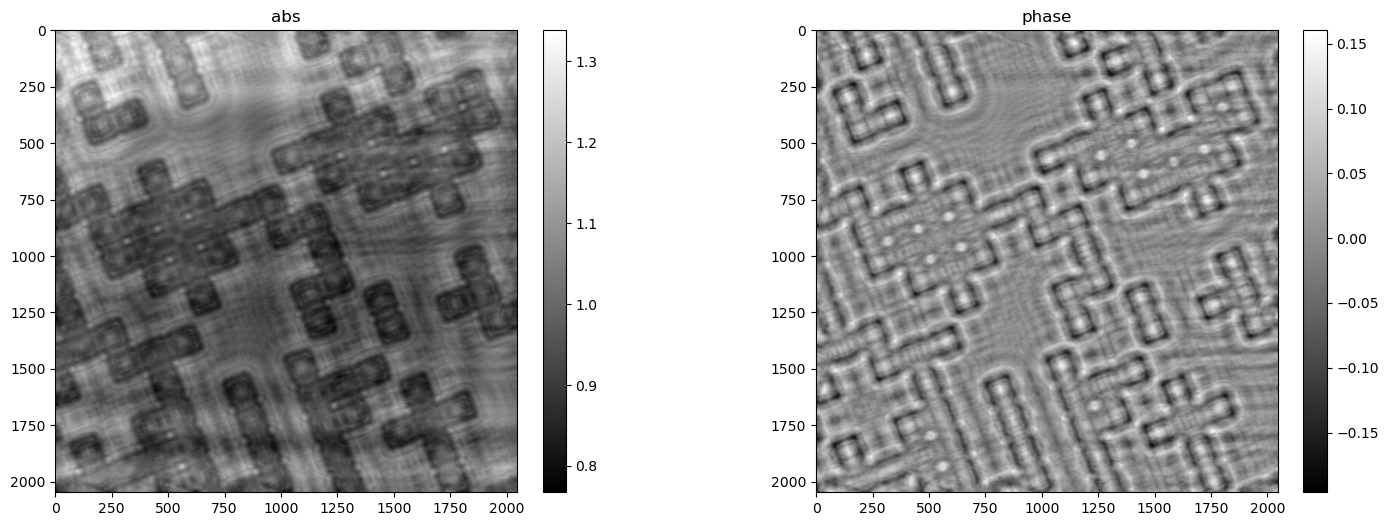

In [6]:
q_init = cp.array(cl_rec.DT(np.sqrt(ref[np.newaxis]))[0])

ppad = 3 * args.pad // 2
q_init = np.pad(
    q_init[ppad : args.nq - ppad, ppad : args.nq - ppad],
    ((ppad, ppad), (ppad, ppad)),
    "symmetric",
)
v = cp.ones(args.nq, dtype="float32")
vv = cp.sin(cp.linspace(0, cp.pi / 2, ppad))
v[:ppad] = vv
v[args.nq - ppad :] = vv[::-1]
v = cp.outer(v, v)
q_init = cp.abs(q_init * v) * cp.exp(1j * cp.angle(q_init) * v)

q_init=q_init.get()
mshow_polar(q_init,args.show)

In [7]:
# psi_abs = read_tiff('/data/visitors/danmax/20241507/2025060408/viktor/ca_250_100/rec_ca/r_0.0_0/rec_psi_abs/0240.tiff')
# psi_angle = read_tiff('/data/visitors/danmax/20241507/2025060408/viktor/ca_250_100/rec_ca/r_0.0_0/rec_psi_angle/0240.tiff')
# q_angle = read_tiff('/data/visitors/danmax/20241507/2025060408/viktor/ca_250_100/rec_ca/r_0.0_0/rec_prb_angle/0240.tiff')
# q_abs = read_tiff('/data/visitors/danmax/20241507/2025060408/viktor/ca_250_100/rec_ca/r_0.0_0/rec_prb_abs/0240.tiff')
# psi = psi_abs*np.exp(1j*psi_angle)
# q = q_abs*np.exp(1j*q_angle)
# ri = np.round(shifts).astype("int32")
# r = np.array(shifts - ri).astype("float32")

# d = cl_rec.fwd(ri,r,psi,q)


In [8]:
# mshow_complex(np.abs(d[0])**2+1j*data[0],True)


In [9]:
# for k in range(npos):
    # mshow(np.abs(d[k])**2-data[k])

In [10]:
# # fig,ax = plt.subplot(1,2)
# fig = plt.figure()
# plt.plot((np.abs(d[0])**2)[700,700:1000],'r')
# plt.plot(data[0][700,700:1000])
# plt.show()
# plt.plot((np.abs(d[0])**2)[700:1000,750],'r')
# plt.plot(data[0][700:1000,750])
# plt.show()


0) err=1.54919e+07


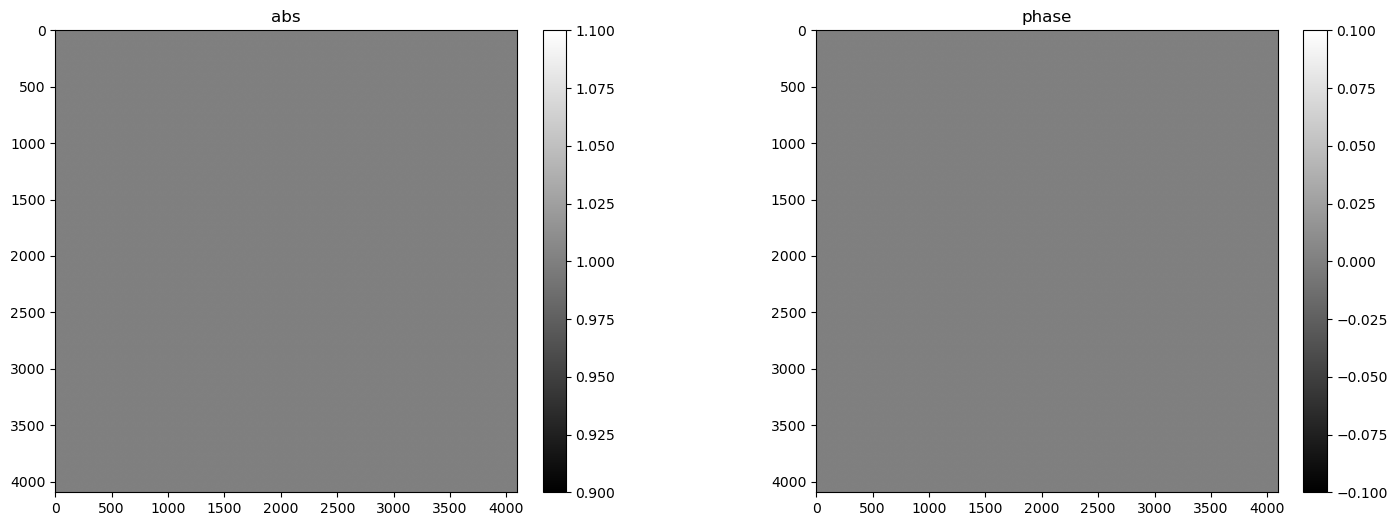

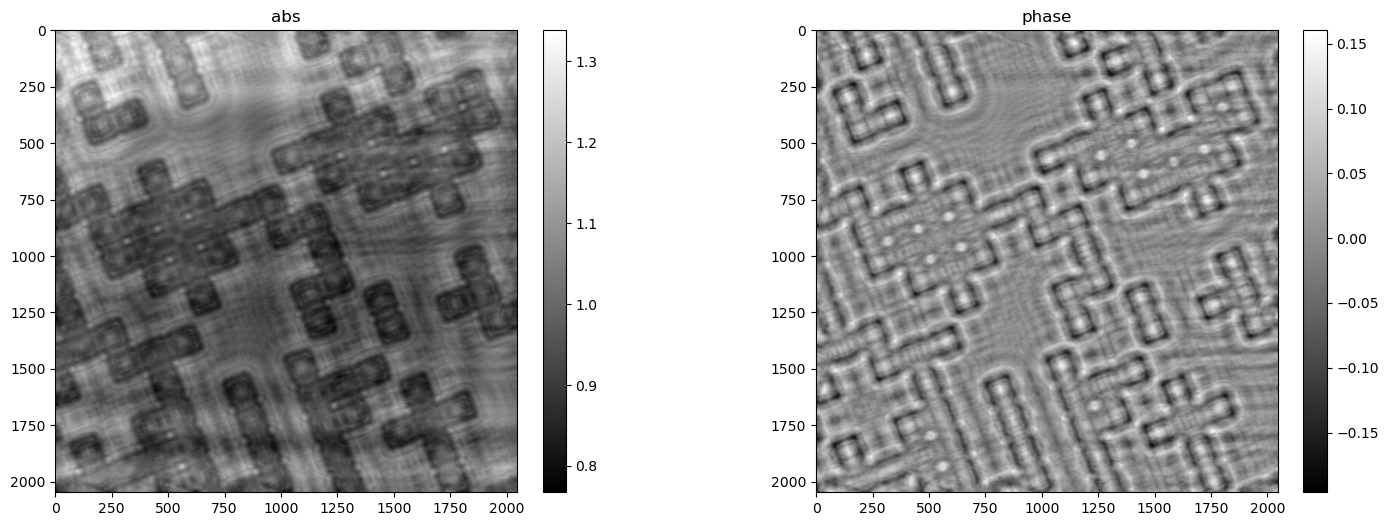

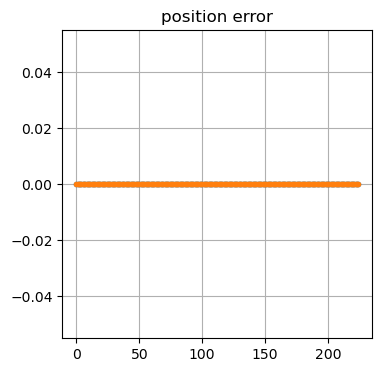

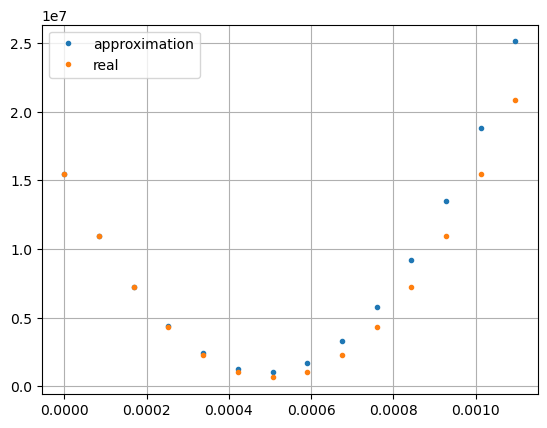

4) err=3.64439e+05
8) err=2.66432e+05
12) err=2.51764e+05
16) err=2.46442e+05


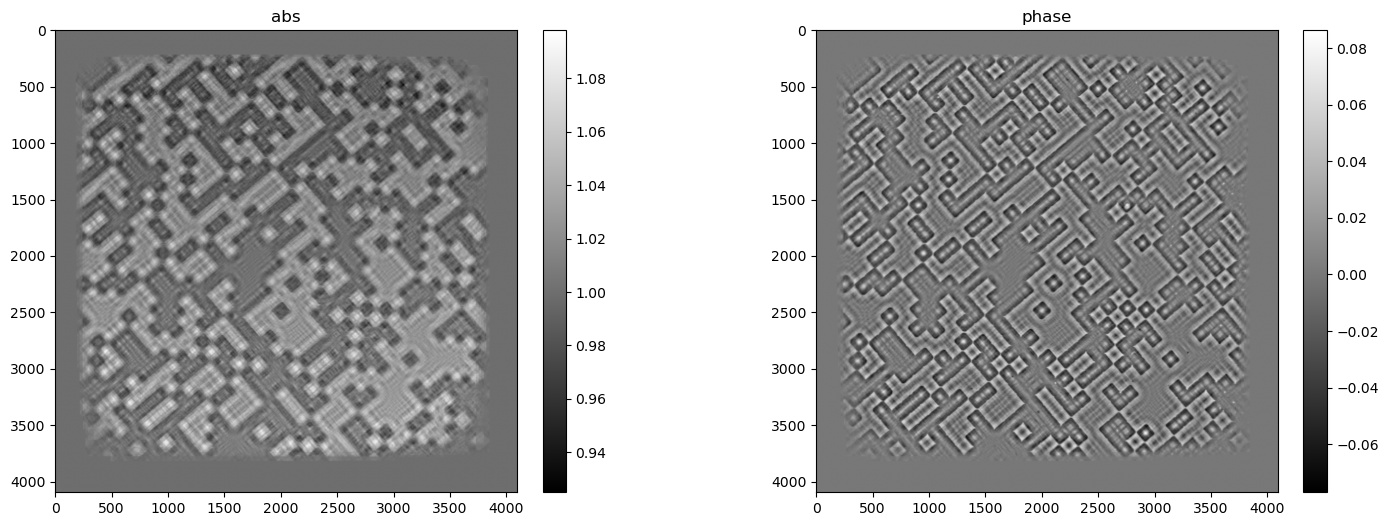

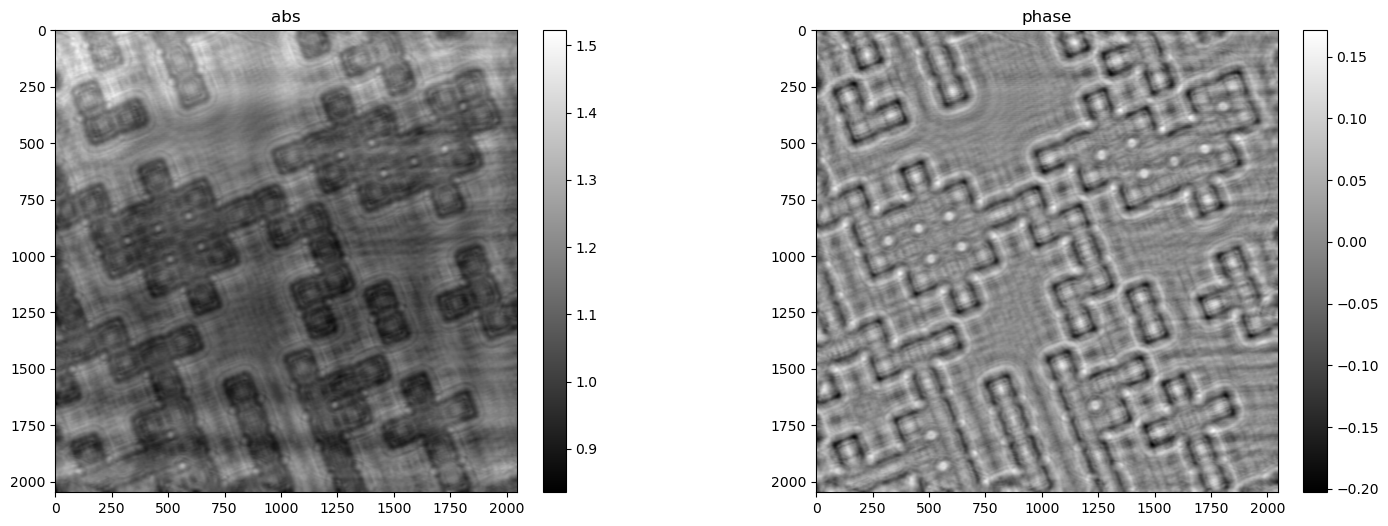

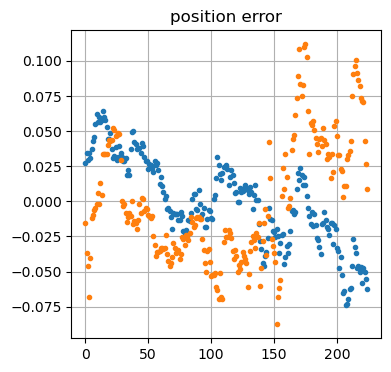

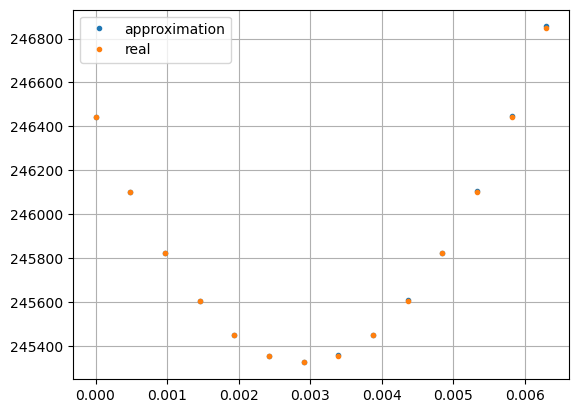

20) err=2.43112e+05
24) err=2.40676e+05
28) err=2.37651e+05
32) err=2.33798e+05


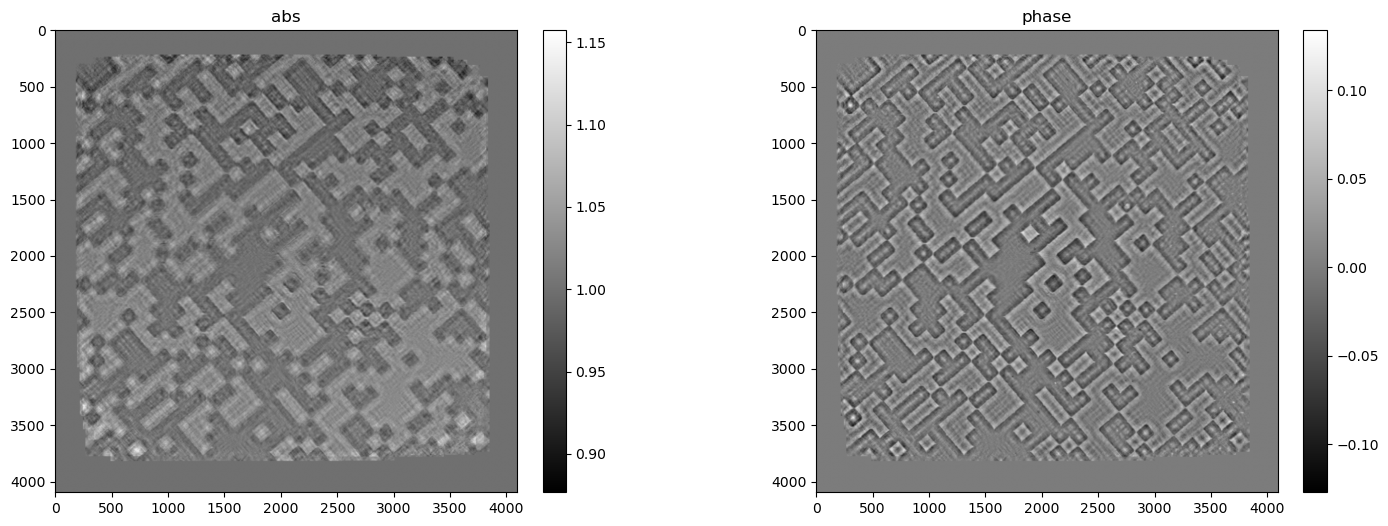

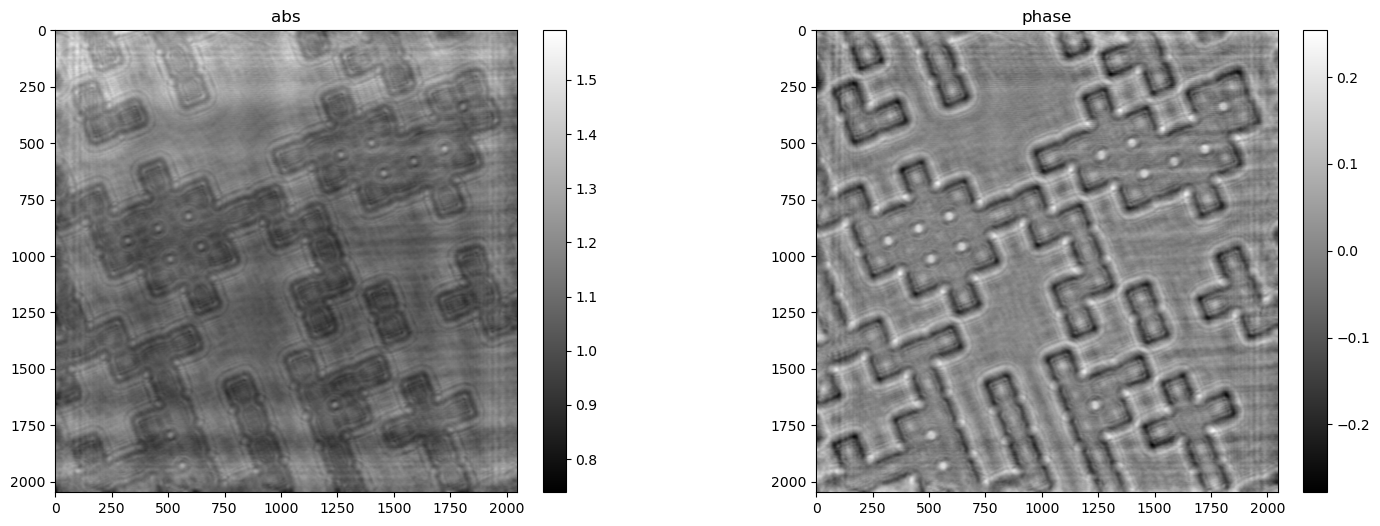

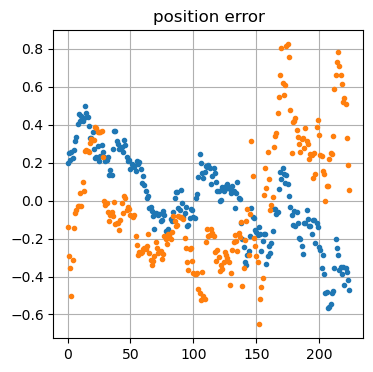

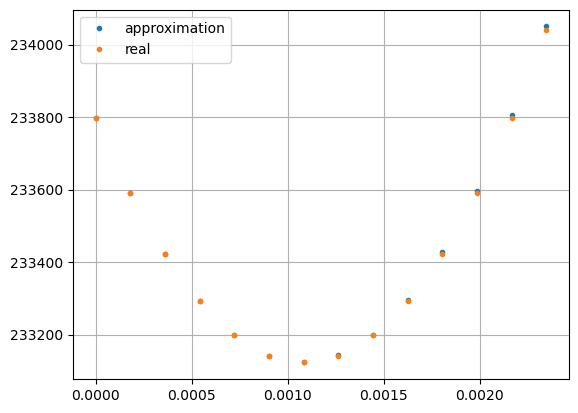

36) err=2.29972e+05
40) err=2.25383e+05
44) err=2.20650e+05
48) err=2.16634e+05


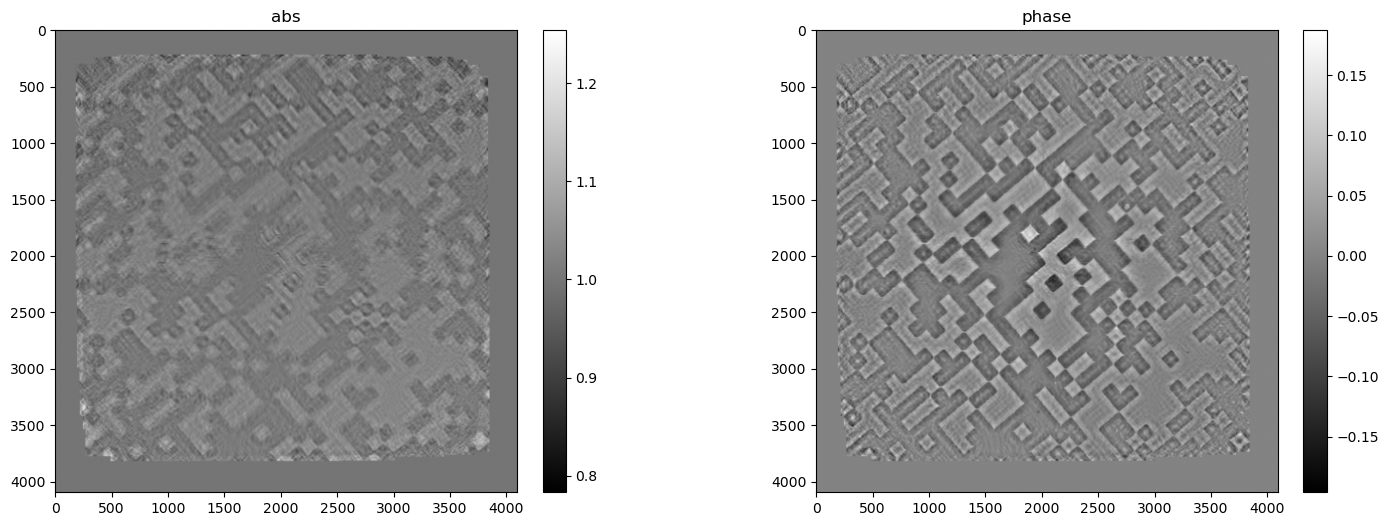

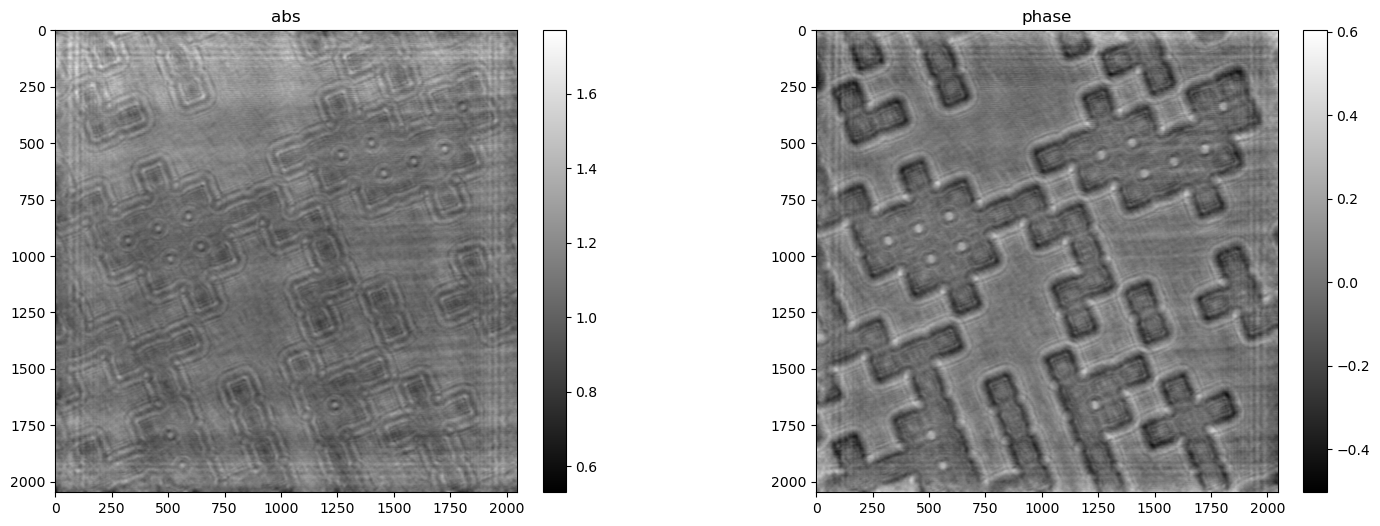

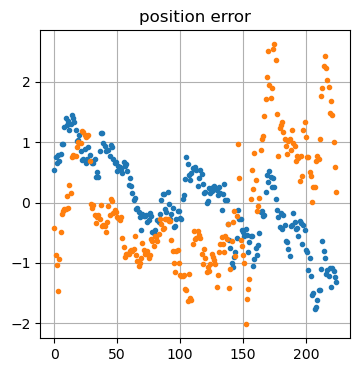

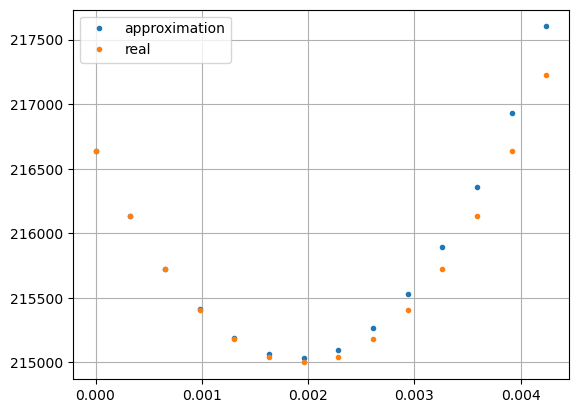

52) err=2.11696e+05
56) err=2.06452e+05
60) err=2.01930e+05
64) err=1.96744e+05


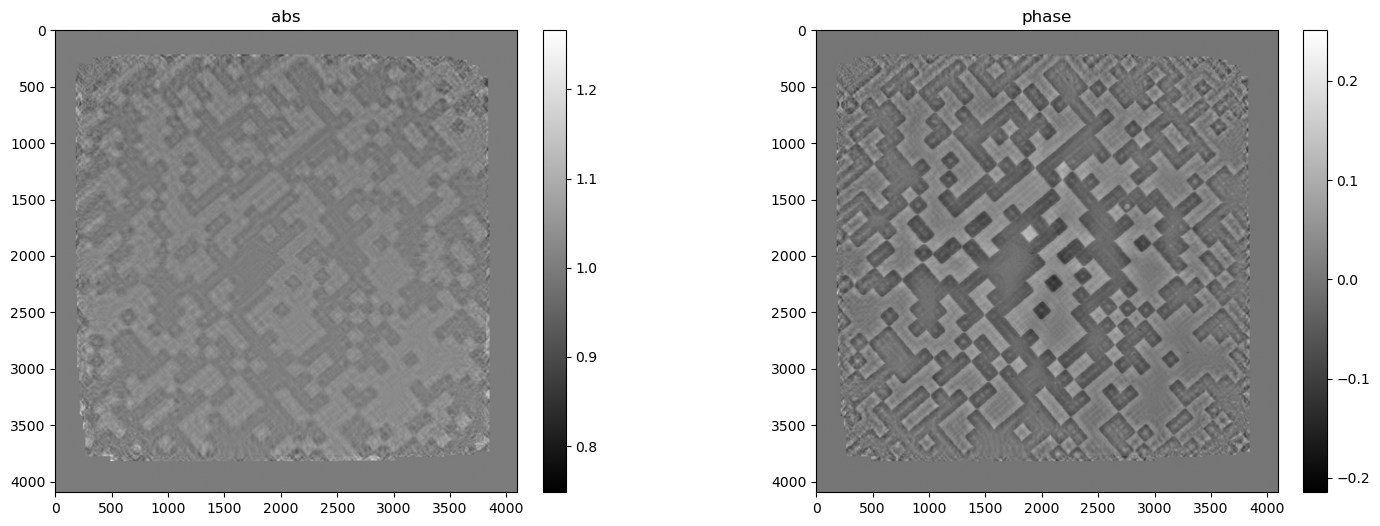

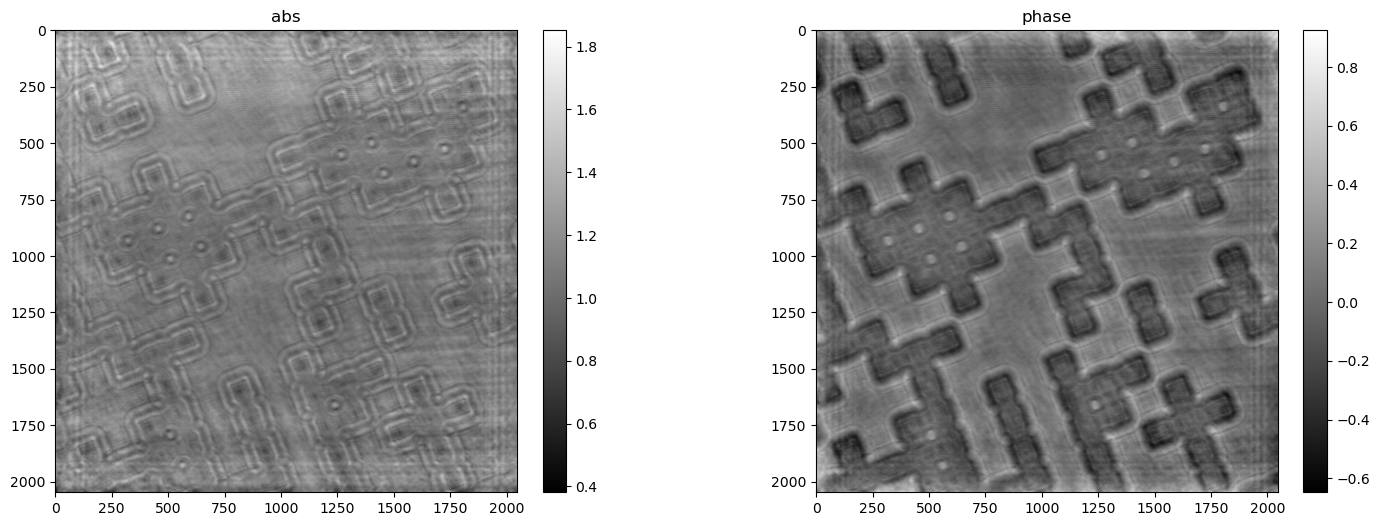

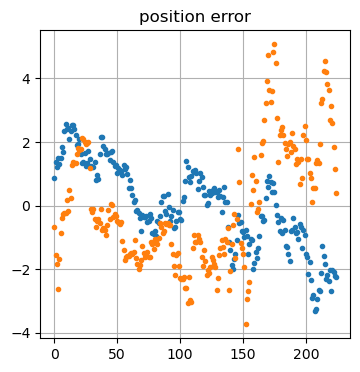

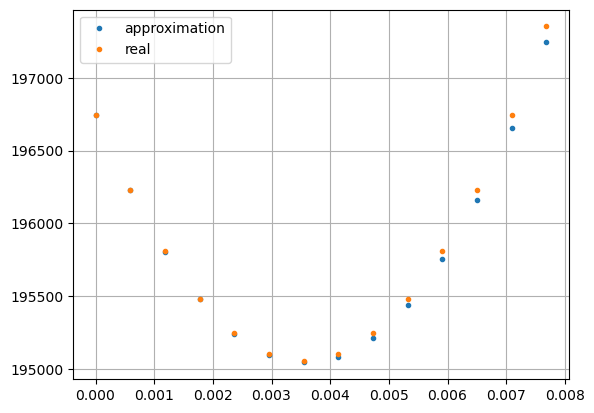

68) err=1.91427e+05
72) err=1.86741e+05
76) err=1.82979e+05
80) err=1.79775e+05


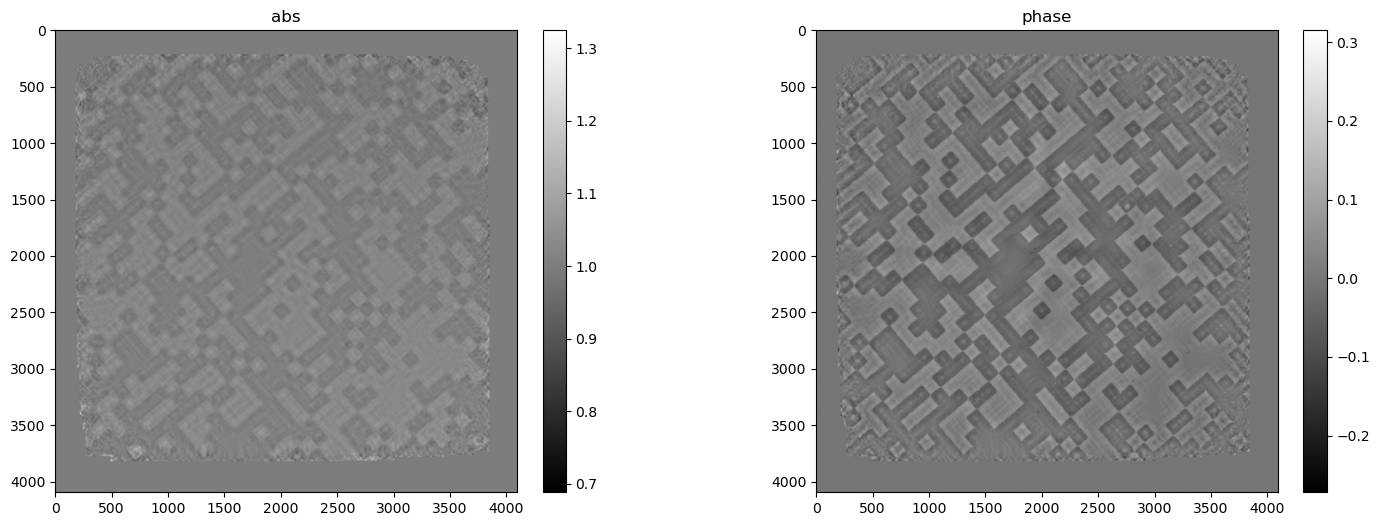

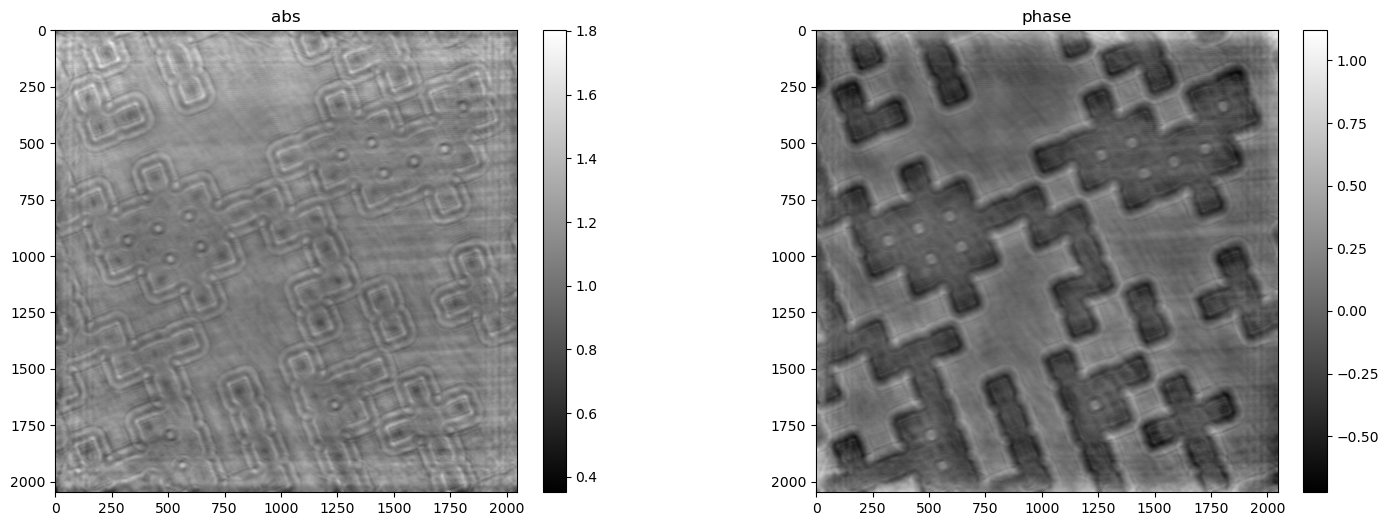

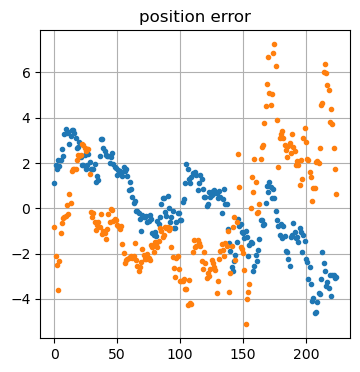

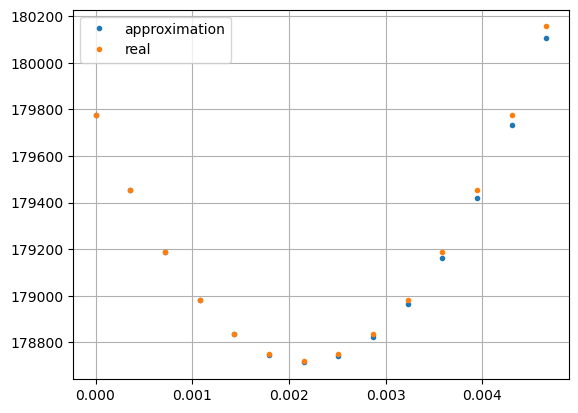

84) err=1.76784e+05
88) err=1.74082e+05
92) err=1.71662e+05


In [ ]:
# variables
vars = {}
vars["psi"] = psi_init.copy()*0+1
vars["q"] = q_init.copy()
vars["ri"] = np.round(shifts).astype("int32")
vars["r"] = np.array(shifts - vars["ri"]).astype("float32")
vars["r_init"] = vars["r"].copy()
vars["table"] = pd.DataFrame(columns=["iter", "err", "time"])
# reconstruction
vars = cl_rec.BH(data, ref, vars)

In [ ]:
mshow(vars['psi'],True)

In [ ]:
# results
erra = vars["table"]["err"].values
plt.plot(erra)
plt.yscale("log")
plt.grid()
mshow_polar(vars["psi"],args.show)
mshow_polar(vars["q"],args.show)
pos_rec = vars["ri"] + vars["r"]
if args.show:
    plt.plot((shifts[:, 1] - pos_rec[:, 1]), ".", label="x difference")
    plt.plot((shifts[:, 0] - pos_rec[:, 0]), ".", label="y difference")
    plt.legend()
    plt.grid()
    plt.plot()